In [1]:
import time
import os
import sys
import numpy as np
#import ipympl
import matplotlib
matplotlib.use('nbagg')
#from matplotlib import style
#style.use('ggplot')
import matplotlib.pyplot as plt

import astropy.units as u
from astropy import stats
from astropy.io import fits
from mmtwfs.wfs import *
from mmtwfs.zernike import ZernikeVector
from mmtwfs.telescope import MMT

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
def wfsrun(wfs, mode, file):
    r = wfs.measure_slopes(file, mode=mode, plot=True)
    return r

# Binospec Dev Section

In [ ]:
bino = WFSFactory(wfs="binospec")

In [ ]:
#%%prun
bino_file = "/Volumes/LaCie 8TB/wfsdat/20180208/wfs_ff_cal_img_2018.0208.074052.fits"
#bino_file = "/Users/tim/MMT/mmtwfs/mmtwfs/data/test_data/wfs_ff_cal_img_2017.1113.111402.fits"
#bino_file = "/Volumes/LaCie 8TB/wfsdat/20180209/wfs_ff_cal_img_2018.0209.114054.fits"
#bino_file = "/Volumes/LaCie 8TB/wfsdat/20180210/wfs_ff_cal_img_2018.0210.095719.fits"
#bino_file = "/Volumes/LaCie 8TB/wfsdat/20180210/wfs_ff_cal_img_2018.0210.102615.fits"
#bino_file = "/Volumes/LaCie 8TB/wfsdat/20180604/wfs_ff_cal_img_2018.0604.052401.fits"
results = bino.measure_slopes(bino_file, mode="binospec", plot=True)
results['figures']['slopes'].show()

In [ ]:
refaps = bino.modes['binospec']['reference'].masked_apertures
fig, ax = plt.subplots()
fit = results['grid_fit']
refx = refaps['xcentroid'] * (fit['scale'] + refaps['xcentroid'] * fit['xcoma']) + fit['xcen']
refy = refaps['ycentroid'] * (fit['scale'] + refaps['ycentroid'] * fit['ycoma']) + fit['ycen']
x, y = results['apertures'].positions.transpose()[0], results['apertures'].positions.transpose()[1]
spacing = 0.5*(results['xspacing'] + results['yspacing'])
ax.scatter(refx, refy)
ax.set_aspect('equal')
ax.scatter(x, y)
ax.set_xlim(0, 512)
ax.set_ylim(0, 512)
fig.show()

results['grid_fit']

In [ ]:
#%%prun
zresults = bino.fit_wavefront(results, plot=True)
zvec = zresults['zernike']
print(zresults['residual_rms'])
#zvec.normalize()
print(zvec.pretty_print())
#print(zvec)
zresults['resid_plot'].show()

In [ ]:
zvec.fringe_bar_chart().show()

In [ ]:
zvec.bar_chart(last_mode=22).show()

In [ ]:
zvec.plot_map().show()

In [ ]:
zv = ZernikeVector(Z38=100)
ft, m1c, zv_masked = bino.telescope.calculate_primary_corrections(zvec, mask=['Z22'])
bino.telescope.to_rcell(ft, filename="null_forces")

In [ ]:
forces, m1focus, zv_masked = bino.calculate_primary(zvec, threshold=0.25*zresults['residual_rms'])

In [ ]:
bino.modes['binospec']['reference']

In [ ]:
bino.modes['binospec']['reference']['xspacing'], bino.modes['binospec']['reference']['yspacing']

In [ ]:
bino.modes['binospec']['reference']['figure'].show()

# MMIRS Dev Section

In [ ]:
mmirs = WFSFactory(wfs="mmirs")

In [ ]:
plt.close('all')
mmirs_file = "/Volumes/LaCie 8TB/wfsdat/20171101/mmirs_wfs_%04d.fits" % 33
#mmirs_file = "/Users/tim/MMT/mmtwfs/mmtwfs/data/test_data/mmirs_wfs_0150.fits"
results = mmirs.measure_slopes(mmirs_file, plot=True)
results['figures']['slopes'].show()

In [ ]:
refaps = mmirs.modes['mmirs1']['reference'].masked_apertures
fig, ax = plt.subplots()
fit = results['grid_fit']
refx = refaps['xcentroid'] * (fit['scale'] + refaps['xcentroid'] * fit['xcoma']) + fit['xcen']
refy = refaps['ycentroid'] * (fit['scale'] + refaps['ycentroid'] * fit['ycoma']) + fit['ycen']
x, y = results['apertures'].positions.transpose()[0], results['apertures'].positions.transpose()[1]
spacing = 0.5*(results['xspacing'] + results['yspacing'])
ax.scatter(refx, refy)
ax.set_aspect('equal')
ax.scatter(x, y)
ax.set_xlim(0, 512)
ax.set_ylim(0, 512)
fig.show()

results['grid_fit']

In [ ]:
zresults = mmirs.fit_wavefront(results, plot=True)
zvec = zresults['zernike']
print(zresults['residual_rms'])
#zvec.normalize()
print(zvec.pretty_print())
zresults['resid_plot'].show()

In [ ]:
zresults['zernike'].fringe_bar_chart().show()

In [ ]:
zresults['zernike'].bar_chart(last_mode=21).show()

In [ ]:
psf, pfig = mmirs.telescope.psf(zresults['zernike'].copy())
pfig.show()

In [ ]:
print(mmirs.modes['mmirs1']['reference']['fwhm'])

spot = mmirs.modes['mmirs1']['reference']['spot']
model = Gaussian2D(amplitude=spot.max(), x_mean=spot.shape[1]/2, y_mean=spot.shape[0]/2) + Polynomial2D(degree=0)
#model = Gaussian2D(amplitude=spot.max(), x_mean=spot.shape[1]/2, y_mean=spot.shape[0]/2)
fitter = LevMarLSQFitter()
y, x = np.mgrid[:spot.shape[0], :spot.shape[1]]
fit = fitter(model, x, y, spot)
fig, ax = plt.subplots()
ax.imshow(mmirs.modes['mmirs1']['reference']['spot'] - fit(x, y))
fig.show()

In [ ]:
mmirs.modes['mmirs1']['reference']['figure'].show()
mmirs.modes['mmirs1']['reference']['xspacing'], mmirs.modes['mmirs1']['reference']['yspacing']

In [ ]:
zplot = zvec.copy()
zplot.ignore('Z02')
zplot.ignore('Z03')
mfig = zplot.plot_map()
mfig.show()
zplot.peak2valley

In [ ]:
zvec.units = u.nm
f = zvec.bar_chart(residual=zresults['residual_rms'])
f.set_size_inches(9, 5)

f.show()

In [ ]:
plt.close(f)

In [ ]:
torig = mmirs.telescope.bending_forces(zvec)
torig.show_in_notebook()

In [ ]:
force_fig = mmirs.telescope.plot_forces(torig)
force_fig.show()

In [ ]:
t, m1foc = mmirs.correct_primary(zv=zvec)
print(m1foc)
t.show_in_notebook()

In [ ]:
new_force_fig = mmirs.telescope.plot_forces(t)
new_force_fig.show()

In [ ]:
zpsf = ZernikeVector()
psf, psf_fig = mmirs.telescope.psf(zpsf, plot=True)
psf_fig.set_size_inches(4.0, 4.0)
psf_fig.show()

# F/9 Dev Section

In [ ]:
plt.close('all')
f9wfs = WFSFactory(wfs="newf9")
#f9wfs = WFSFactory(wfs="newf9", pup_offset=[0.0, 0.0])

In [ ]:
f9wfs.modes['blue']['reference'].figure.show()

In [ ]:
baseline1_files = ["f9wfs_20180131-191734.fits", "f9wfs_20180131-191925.fits", "f9wfs_20180131-192131.fits"]
baseline2_files = ["f9wfs_20180131-192350.fits", "f9wfs_20180131-192541.fits", "f9wfs_20180131-192731.fits"]
baseline3_files = [
    "f9wfs_20180131-192927.fits", "f9wfs_20180131-193109.fits", 
    "f9wfs_20180131-193325.fits", "f9wfs_20180131-193509.fits"
]

In [ ]:
plt.close('all')
f9_file = "/Volumes/LaCie 8TB/wfsdat/20180201/" + baseline2_files[0]
#f9_file = "/Users/tim/MMT/mmtwfs/mmtwfs/data/test_data/test_newf9.fits"
#f9_file = "/Users/tim/MMT/wfsdat/test/f9wfs_20180908-220524.fits"
#f9_file = "/Users/tim/MMT/wfsdat/latest/f9wfs_20180909-195218.fits"
results = f9wfs.measure_slopes(f9_file, 'blue', plot=True)
#plt.scatter(refaps['xcentroid']+results['xcen'], refaps['ycentroid']+results['ycen'])
results['figures']['slopes'].show()
# 265 258
# ref 240 259.5

In [ ]:
zresults = f9wfs.fit_wavefront(results, plot=True)
print(zresults['residual_rms'])
print(zresults['zernike'].pretty_print())
zresults['resid_plot'].show()

In [ ]:
results['ref_mask']

In [ ]:
f9wfs.modes['blue']['reference'].xcen

In [ ]:
refaps = f9wfs.modes['blue']['reference'].masked_apertures
fig, ax = plt.subplots()
fit = results['grid_fit']
refx = refaps['xcentroid'] * (fit['scale'] + refaps['xcentroid'] * fit['xcoma']) + fit['xcen']
refy = refaps['ycentroid'] * (fit['scale'] + refaps['ycentroid'] * fit['ycoma']) + fit['ycen']
x, y = results['apertures'].positions.transpose()[0], results['apertures'].positions.transpose()[1]
spacing = 0.5*(results['xspacing'] + results['yspacing'])
ax.scatter(refx, refy)
ax.set_aspect('equal')
ax.scatter(x, y)
ax.set_xlim(0, 845)
ax.set_ylim(0, 845)
fig.show()
fit['scale']

In [ ]:
data = check_wfsdata(f9_file)
x = np.arange(data.shape[1])
y = np.arange(data.shape[0])
bx = np.arange(data.shape[1]+1)
by = np.arange(data.shape[0]+1)
apertures = results['spots']

# bin the spot positions along the axes and use Lomb-Scargle to measure the grid spacing in each direction
xsum = np.histogram(apertures['xcentroid'], bins=bx)
ysum = np.histogram(apertures['ycentroid'], bins=by)

k = np.linspace(10.0, 50., 500)  # look for spacings from 5 to 50 pixels (plenty of range)
f = 1.0 / k  # convert spacing to frequency
xp = stats.LombScargle(x, xsum[0]).power(f)
yp = stats.LombScargle(y, ysum[0]).power(f)
plt.plot(k, yp)
plt.show()

In [ ]:
zresults['zernike'].bar_chart(last_mode=21).show()

In [ ]:
zresults['zernike'].fringe_bar_chart().show()

In [ ]:
spots = {'xcentroid': x, 'ycentroid': y}
from scipy import optimize

def match_apertures(refx, refy, spotx, spoty):
    tot_dist = 0.0
    refs = np.array([refx, refy])
    spots = np.array([spotx, spoty])
    match = np.empty(len(refx))
    max_r = spacing / 2.
    for i in np.arange(len(refx)):
        dists = np.sqrt( (spots[0]-refs[0][i])**2 + (spots[1]-refs[1][i])**2 )
        tot_dist += np.min(dists)
    return tot_dist

def fit_apertures(pars, ref, spots):
    xc = pars[0]
    yc = pars[1]
    xscale = pars[2]
    yscale = pars[3]
    xcoma = pars[4]
    ycoma = pars[5]
    refx = ref['xcentroid'] * (xscale + ref['xcentroid'] * xcoma) + xc
    refy = ref['ycentroid'] * (yscale + ref['ycentroid'] * ycoma) + yc
    spotx = spots['xcentroid']
    spoty = spots['ycentroid']
    dist = match_apertures(refx, refy, spotx, spoty)
    return dist

In [ ]:
#%%timeit
args = (refaps, spots)
pars = (results['xcen'], results['ycen'], 1.0, 1.0, 0.0, 0.0)
bounds = (
    (results['xcen']-50, results['xcen']+50), 
    (results['ycen']-50, results['ycen']+50),
    (0.8, 1.2),
    (0.8, 1.2),
    (-0.1, 0.1),
    (-0.1, 0.1)
)
res = optimize.minimize(fit_apertures, pars, args=args, bounds=bounds)
res

In [ ]:
fig, ax = plt.subplots()
refx, refy = refaps['xcentroid'], refaps['ycentroid']
refx = refx * (res['x'][2] + refx*res['x'][4]) + res['x'][0]
refy = refy * (res['x'][3] + refy*res['x'][5]) + res['x'][1]
x, y = results['apertures'].positions.transpose()[0], results['apertures'].positions.transpose()[1]
ax.scatter(refx, refy)
ax.set_aspect('equal')
ax.scatter(x, y)
ax.set_xlim(0, 845)
ax.set_ylim(0, 845)
fig.show()

In [ ]:
print(f9wfs.modes['blue']['reference']['xcen'], f9wfs.modes['blue']['reference']['ycen'])
print(f9wfs.modes['blue']['reference']['xspacing'], f9wfs.modes['blue']['reference']['yspacing'])
f9wfs.modes['blue']['reference'].keys()

In [ ]:
zv = zresults['zernike']
print(zv.rms)
zv.ignore('Z02')
zv.ignore('Z03')
f = zv.plot_map()
f.show()

In [ ]:
bc = zv.bar_chart(residual=zresults['residual_rms'])
bc.show()

In [ ]:
psf, psf_fig = f9wfs.telescope.psf(zv, fov=1.0)
psf_fig.show()

In [ ]:
plt.close('all')

# F/5 Dev Section

In [36]:
f5wfs = WFSFactory(wfs="f5")

<IPython.core.display.Javascript object>


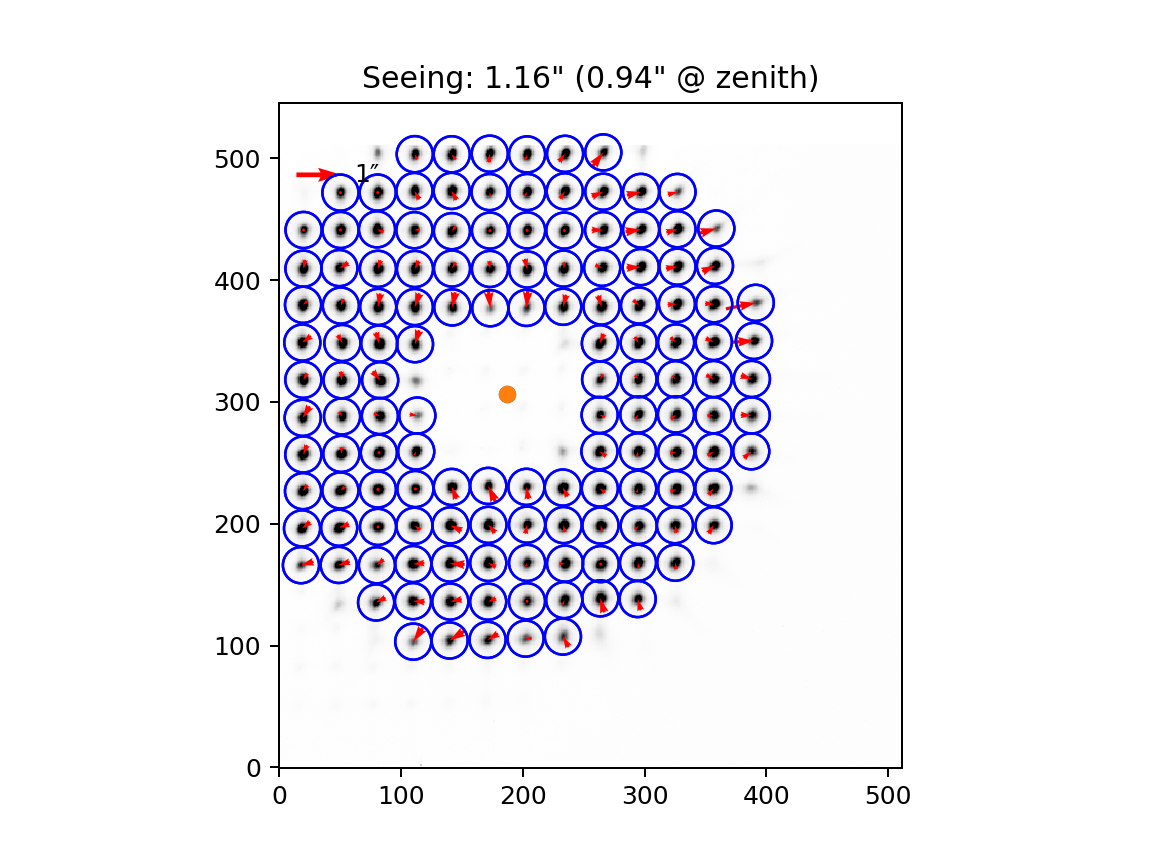

In [37]:
#%%prun
plt.close('all')
f5_file = "/Volumes/LaCie 8TB/wfsdat/20181022/manual_wfs_0003.fits"
#f5_file = "/Users/tim/MMT/mmtwfs/mmtwfs/data/test_data/auto_wfs_0037_ave.fits"
f5_file = "/Users/tim/MMT/wfsdat/pointing/manual_wfs_0005.fits"
results = f5wfs.measure_slopes(f5_file, 'hecto', plot=True)
results['figures']['slopes'].show()

In [38]:
f5wfs.calculate_recenter(results), results['xcen'], results['ycen']

((<Quantity -9.954 arcsec>, <Quantity 1.905 arcsec>),
 187.25329555257395,
 306.36357560103517)

Fringe Coefficients
 Z02:          -642 ±   228 nm 	 X Tilt (1, 1)
 Z03:        -299.6 ±   257 nm 	 Y Tilt (1, -1)
 Z04:         47.32 ±   134 nm 	 Defocus (2, 0)
 Z05:          1377 ±   292 nm 	 Primary Astig at 45° (2, -2)
 Z06:        -526.5 ±   282 nm 	 Primary Astig at 0° (2, 2)
 Z07:         91.96 ±   194 nm 	 Primary Y Coma (3, -1)
 Z08:         509.9 ±   200 nm 	 Primary X Coma (3, 1)
 Z09:         33.22 ±   234 nm 	 Y Trefoil (3, -3)
 Z10:        -457.2 ±   262 nm 	 X Trefoil (3, 3)
 Z11:        -500.4 ±   107 nm 	 Primary Spherical (4, 0)
 Z12:        -301.8 ±  88.2 nm 	 Secondary Astigmatism at 0° (4, 2)
 Z13:        -262.5 ±  73.9 nm 	 Secondary Astigmatism at 45° (4, -2)
 Z14:         13.94 ±   130 nm 	 X Tetrafoil (4, 4)
 Z15:         3.232 ±   109 nm 	 Y Tetrafoil (4, -4)
 Z16:        -75.52 ±  88.9 nm 	 Secondary X Coma (5, 1)
 Z17:         27.15 ±  75.7 nm 	 Secondary Y Coma (5, -1)
 Z18:        -73.31 ±  78.5 nm 	 Secondary X Trefoil (5, 3)
 Z19:        -126.7 ±    74

<IPython.core.display.Javascript object>


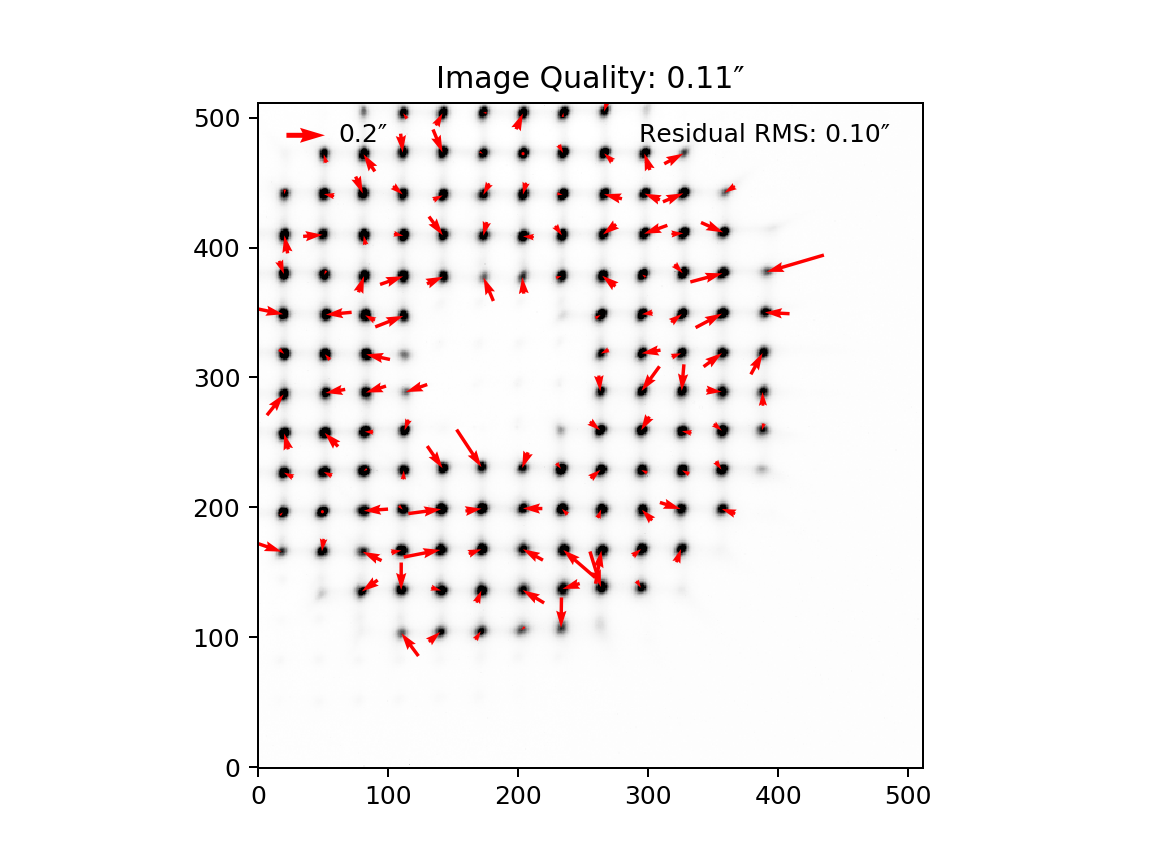

In [39]:
#%%prun
zresults = f5wfs.fit_wavefront(results, plot=True)
zv = zresults['zernike']
print(zv.pretty_print())
print(zv.rms)
zresults['resid_plot'].show()

<IPython.core.display.Javascript object>


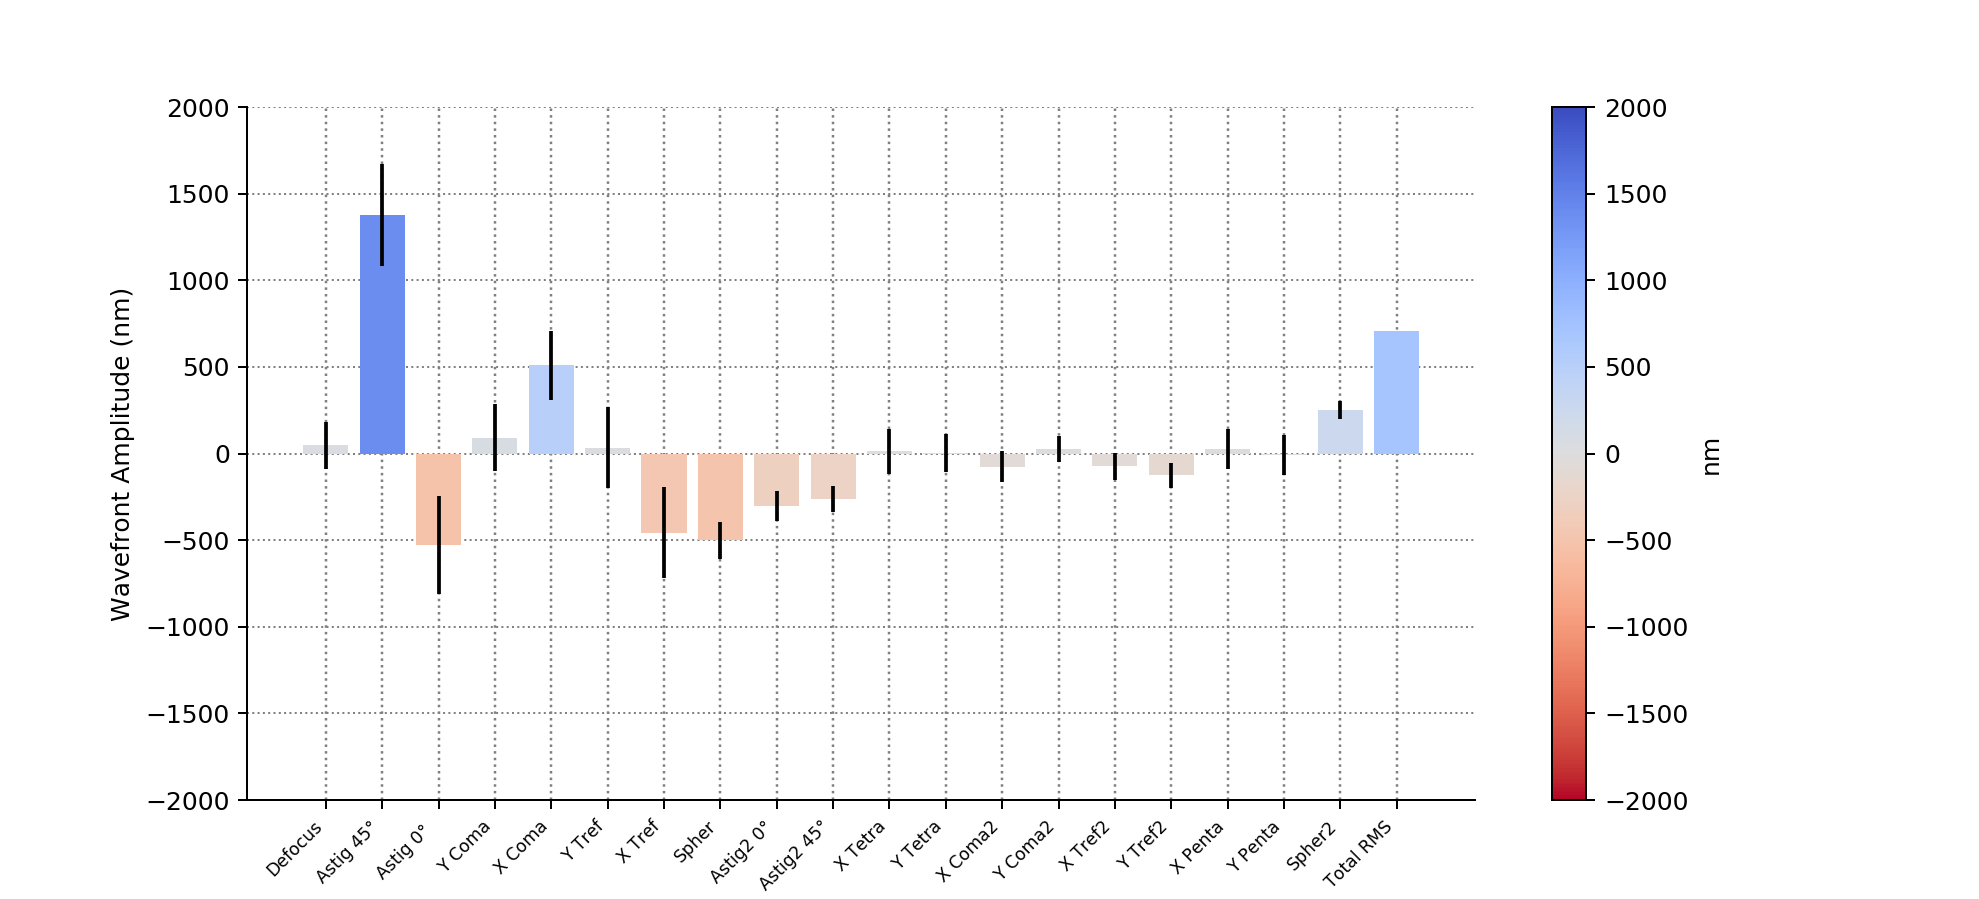

<Quantity 1563.30945331 nm>

In [40]:
zf = zv.fringe_bar_chart()
zf.show()
zresults['residual_rms']

In [ ]:
bc = zv.bar_chart(last_mode=21)
bc.show()

In [46]:
zv.denormalize()
zv

Fringe Coefficients
 Z02:          -642 ±   228 nm 	 X Tilt (1, 1)
 Z03:        -299.6 ±   257 nm 	 Y Tilt (1, -1)
 Z04:         47.32 ±   134 nm 	 Defocus (2, 0)
 Z05:          1377 ±   292 nm 	 Primary Astig at 45° (2, -2)
 Z06:        -526.5 ±   282 nm 	 Primary Astig at 0° (2, 2)
 Z07:         91.96 ±   194 nm 	 Primary Y Coma (3, -1)
 Z08:         509.9 ±   200 nm 	 Primary X Coma (3, 1)
 Z09:         33.22 ±   234 nm 	 Y Trefoil (3, -3)
 Z10:        -457.2 ±   262 nm 	 X Trefoil (3, 3)
 Z11:        -500.4 ±   107 nm 	 Primary Spherical (4, 0)
 Z12:        -301.8 ±  88.2 nm 	 Secondary Astigmatism at 0° (4, 2)
 Z13:        -262.5 ±  73.9 nm 	 Secondary Astigmatism at 45° (4, -2)
 Z14:         13.94 ±   130 nm 	 X Tetrafoil (4, 4)
 Z15:         3.232 ±   109 nm 	 Y Tetrafoil (4, -4)
 Z16:        -75.52 ±  88.9 nm 	 Secondary X Coma (5, 1)
 Z17:         27.15 ±  75.7 nm 	 Secondary Y Coma (5, -1)
 Z18:        -73.31 ±  78.5 nm 	 Secondary X Trefoil (5, 3)
 Z19:        -126.7 ±    74

In [ ]:
refaps = f5wfs.modes['hecto']['reference'].masked_apertures
fig, ax = plt.subplots()
fit = results['grid_fit']
refx = refaps['xcentroid'] * (fit['scale'] + refaps['xcentroid'] * fit['xcoma']) + fit['xcen']
refy = refaps['ycentroid'] * (fit['scale'] + refaps['ycentroid'] * fit['ycoma']) + fit['ycen']
x, y = results['apertures'].positions.transpose()[0], results['apertures'].positions.transpose()[1]
spacing = 0.5*(results['xspacing'] + results['yspacing'])
ax.scatter(refx, refy)
ax.set_aspect('equal')
ax.scatter(x, y)
ax.set_xlim(0, 512)
ax.set_ylim(0, 512)
fig.show()

In [ ]:
zv.ignore('Z02')
zv.ignore('Z03')
zv.ignore('Z04')
print(zv.rms)
mf = zv.plot_map()
mf.show()

In [ ]:
t, m1foc = f5wfs.telescope.calculate_primary_corrections(zresults['zernike'])

In [ ]:
fplot = f5wfs.telescope.plot_forces(t, m1focus=m1foc)
fplot.show()

In [ ]:
t.show_in_notebook()

# Scratch space

In [ ]:
cen = center_pupil(subt, pup, plot=True)
print(cen)
plt.show()

In [ ]:
from astropy.io import ascii

In [ ]:
t = f9wfs.telescope
m = t.zern_map

In [ ]:
z = np.loadtxt("/Users/tim/MMT/wfsdat/20170110/mmirs_wfs_0375.dao.sub.zrn.cor")
z1 = np.loadtxt("/Users/tim/MMT/wfsdat/20170110/mmirs_wfs_0375.dao.av.zrn")

In [ ]:
sigma = results['fwhm'] * stats.funcs.gaussian_fwhm_to_sigma

wave = 650 * u.nm
wave = wave.to(u.m).value  # r_0 equation expects meters so convert
# calculate the physical size of each aperture.
ref = mmirs.modes['mmirs2']['reference']
apsize_pix = np.max((ref['xspacing'], ref['yspacing']))
d = mmirs.telescope.diameter * apsize_pix / mmirs.pup_size
d = d.to(u.m).value  # r_0 equation expects meters so convert

# we need to deconvolve the instrumental spot width from the measured one
ref_sigma = ref['sigma']
if sigma > ref_sigma:
    corr_sigma = np.sqrt(sigma**2 - ref_sigma**2)
else:
    corr_sigma = 0.0
corr_sigma *= mmirs.pix_size.to(u.rad).value  # r_0 equation expects radians so convert
# this equation relates the motion within a single aperture to the characteristic scale size of the
# turbulence, r_0.
r_0 = ( 0.179 * (wave**2) * (d**(-1./3.))/corr_sigma**2 )**0.6
print(r_0)
# this equation relates the turbulence scale size to an expected image FWHM at the given wavelength.
raw_seeing = u.rad * 0.98 * wave / r_0
raw_seeing = raw_seeing.to(u.arcsec)


In [ ]:
t = bino.telescope

In [ ]:
z = ZernikeVector(Z11=-1000*u.nm)
z.plot_map()
plt.show()

In [ ]:
ft, m1, zv_masked = t.calculate_primary_corrections(z)

In [ ]:
ft['force'].min()

In [ ]:
m1

In [ ]:
derot_phi = phi - u.Quantity(225*u.deg, u.rad).value
pol2cart([dr, derot_phi])

In [ ]:
u.Quantity(225*u.deg, u.rad).value

In [ ]:
dx, dy

In [ ]:
t = mmirs.telescope
zv = ZernikeVector(Z05=1000, Z11=250)
force, focus = t.correct_primary(zv)
f1 = focus.copy()
uforce, ufocus = t.undo_last()
print(ufocus)
print(f1)
assert(ufocus == -1 * f1)

In [ ]:
focus.copy()

In [ ]:
np.allclose(np.zeros(2), 0.0)

In [ ]:
s = "offset_inc wfs z 200.3"
assert("200.3" in s)

In [ ]:
fig, ax = plt.subplots()

In [ ]:
ax.imshow(results['data'], cmap=cm.Greys)
fig.savefig("test.png")

In [ ]:
a = fig.axes[0]

In [ ]:
fig.show()

In [ ]:
"{0:0.0f}".format((550 * u.nm))

In [ ]:
x, y, r, p, ph = zvec.phase_map(n=100)
i = np.argsort(x)

In [ ]:
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)

In [ ]:
data = [go.Heatmap(z=np.array(ph[i]), x=x[i], y=y[i], colorscale='RdBu')]
layout = go.Layout(title="test")
fig = go.Figure(data=data, layout=layout)
plot(fig, filename="blah")

In [ ]:
np.min(ph)

In [ ]:
0.119 * 5.4*3/20

In [ ]:
if 'HOME' in os.environ:
    print('y')

In [ ]:
np.zeros((512, 512)).shape

In [ ]:
zv = ZernikeVector()

In [ ]:
zv.plot_map()

In [ ]:
t = MMT()
zv = ZernikeVector(Z05=1000, Z11=250)
force, focus = t.calculate_primary_corrections(zv)

In [ ]:
lforce, lfocus = t.correct_primary(force, focus)

In [ ]:
uforce, ufocus = t.undo_last()

In [ ]:
focus, lfocus, ufocus

In [ ]:
newf9 = WFSFactory(wfs="newf9")

In [ ]:
newf9.modes['blue']['reference']

In [ ]:
x = newf9.modes['blue']['reference']['apertures']['xcentroid'] + newf9.modes['blue']['reference']['xcen']

In [ ]:
y = newf9.modes['blue']['reference']['apertures']['ycentroid'] + newf9.modes['blue']['reference']['ycen']

In [ ]:
arr = np.array((x.data, y.data)).transpose()

In [ ]:
np.savetxt("blah.txt", arr, fmt="%.3f")

In [ ]:
np.savetxt?

In [ ]:
x, y = 405, 445
xnew, ynew = 438, 469
xref, yref = 433, 431
pixsize = 0.09639

rot = u.Quantity(-225 * u.deg, u.rad).value

dx = x - xref
dy = y - yref

dr, phi = cart2pol([dx, dy])

derot_phi = phi - rot

az, el = pol2cart([dr, derot_phi])
print(az, el)

In [ ]:
x, y = 405, 445
xnew, ynew = 438, 469
xref, yref = 433, 431
pixsize = 0.09639

rot = u.Quantity(-225 * u.deg, u.rad).value

dx = 1 * (x - xref)
dy = 1 * (y - yref)

dr, phi = cart2pol([dx, dy])

derot_phi = phi - rot

az, el = pol2cart([dr, derot_phi])
print(az, el)

In [ ]:
azcorr = 3.0 / pixsize
elcorr = 0.9 / pixsize
drc, phic = cart2pol([azcorr, elcorr])
derot_phic = phic + rot
az_pix, el_pix = pol2cart([drc, derot_phic])
print(az_pix, el_pix)

In [ ]:
a = np.arange(5)

In [ ]:
np.delete(a, 2)

In [ ]:
2320-2820

In [ ]:
x1, y1 = 274, 288
x2, y2 = 243, 314
xc, yc = 255, 255
rot_def = 234 * u.deg
rotation = u.Quantity(rot_def, u.rad).value

In [ ]:
x1, y1 = 212, 238
x2, y2 = 243, 314
xc, yc = 255, 255
rot_def = 234 * u.deg
rotation = u.Quantity(rot_def, u.rad).value

In [ ]:
x1, y1 = 358, 308
xc, yc = 419, 439
rot_def = -225 * u.deg
rotation = u.Quantity(rot_def, u.rad).value

In [ ]:
dx = x1 - xc
dy = y1 - yc

In [ ]:
dr, phi = cart2pol([dx, dy])

In [ ]:
derot_phi = rotation + phi

In [ ]:
az, el = pol2cart([dr, derot_phi])
az, el

In [ ]:
az*0.0936, el*0.0936

In [ ]:
1.26 * 3600 / 4156

In [ ]:
z = ZernikeVector(Z04=100)

In [ ]:
z

In [ ]:
z.ignore("Z04")

In [ ]:
z

In [ ]:
for i in range(23,37):
    print("Z{0:02d}".format(i))

In [ ]:
for z in zv:
    print(zv[z])

In [ ]:
np.zeros(0)

In [ ]:
data = check_wfsdata("/Users/tim/MMT/wfsdat/20180604/wfs_ff_cal_img_2018.0604.052401.fits")
#data = check_wfsdata("/Users/tim/MMT/wfsdat/20171101/mmirs_wfs_0022.fits")
#data = check_wfsdata("/Volumes/LACIE SHARE/wfsdat/20180424/f9wfs_20180423-234645.fits")
#data = check_wfsdata("/Users/tim/MMT/wfsdat/20180404/manual_wfs_0004.fits")
fix, ax = plt.subplots()
norm = wfs_norm(data)
ax.imshow(data, cmap='Greys', origin='lower', norm=norm, interpolation='None')
ax.set_title("Binospec WFS")
plt.savefig("/Users/tim/MMT/spie/2018/bino.pdf")
plt.show()

In [ ]:
refdata = check_wfsdata("/Users/tim/MMT/mmtwfs/mmtwfs/data/ref_images/f9_new_ref.fits")
refdata = refdata - np.median(refdata)
apertures, figure = wfsfind(refdata, fwhm=4.0, threshold=30, plot=True)
figure.show()

In [ ]:
25500/390

In [ ]:
18430/300